<h1> Introduction to Topic Modelling</h1>

Topic Modeling is an unsupervised learning approach to clustering documents, to discover topics based on their contents. It is a frequently used text-mining tool for discovery of hidden semantic structures in a text body. 

In this project, we’ll take a closer look at one of the popular topic models, Latent Dirichlet Allocation (LDA).

<h2>Overview of Latent Dirichlet Allocation (LDA)</h2>
LDA is a popular form of statistical topic modeling where documents are represented as a mixture of topics and a topic is a bunch of words. Those topics reside within a hidden, also known as a latent layer. 

LDA looks at a document to determine a set of topics that are likely to have generated that collection of words. Hence, if a document uses certain words that are contained in a topic, you could say the document is about that topic.

Although a topic is composed of words, the likely distribution of those words is not equal. For example, the topic “sports” may have a probability of 50% football, 30% basketball, 20% baseball.

LDA consists of two parts, the words within a document (a known factor) and the probability of words belonging to a topic, which is what needs to be calculated. The algorithm tries to determine, for a given document, how many words belong to a specific topic. Additionally, it attempts to determine how many documents belong to a specific topic based on a certain word.

<h2>Importing libraries</h2>

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re,random,os
import seaborn as sns


from nltk.corpus import stopwords
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

# stemming - English
from nltk.stem import PorterStemmer

# spacy for basic processing, optional, can use nltk as well(lemmatisation etc.)
import spacy

#gensim for LDA
import gensim
from gensim import corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import string
from pathlib import Path
from pprint import pprint

# plotting tools
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

from sklearn.decomposition import LatentDirichletAllocation

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liko_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liko_\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\liko_\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


<h2>Defining stopwords</h2>

In [2]:
original_stopwords = nltk.corpus.stopwords.words('english')

# update stopwords
domain_stop = ['said', 'mr']
domain_stop_update = ['would', 'also', 'could', 'make', 'two', 'made', 'like', 'say', 'one', 'people', 'new', 'year', 'use']
domain_stop_update1 = ['get', 'many', 'come', 'let', 'go', 'went', 'see', 'saw', 'still', 'take', 'know', 'want']
stopwords = set(original_stopwords+domain_stop+domain_stop_update+domain_stop_update1)

leftover = list(set(stopwords)-set(original_stopwords))

In [3]:
print(len(original_stopwords))
print(leftover)
print(len(leftover))

179
['say', 'take', 'people', 'year', 'saw', 'also', 'get', 'could', 'would', 'like', 'come', 'see', 'two', 'new', 'want', 'know', 'make', 'many', 'said', 'mr', 'use', 'made', 'still', 'let', 'one', 'go', 'went']
27


<h2>Initialising lemmatizer and stemmer</h2>

In [4]:
# initialise lemmatizer
lemma = WordNetLemmatizer()

# initialise stemmer
stemmer = PorterStemmer()

<h2>Loading data</h2>

For this project, we will use the dataset consisting of 250 news article set from BBC news.
We will explore building LDA models on various datasets using the gensim implementation of LDA.

At the same time, we will also perform lemmatisation in NLTK, it is slightly more convenient and less verbose than in spaCy. 

For visualising the topics and the word-topic distributions interactively, we'll use the 'pyLDAvis' module.

In [5]:
# r is the raw string literal so that windows path slash won't create a problem
data_folder = Path(r'news2')

# read file from the directory into array and name it corpus
corpus = []
filenames = []

for filename in data_folder.iterdir():
    fp = open(str(filename), 'r', encoding = "ISO-8859-1")
    corpus.append(fp.read())
    #keep filename for later use
    filenames.append(filename.name)
    fp.close()
    
print(str(corpus.__len__()) + " files") # print len of corpus (should be 250 files)

250 files


<h2>Cleaning:
    
<font size="4.5">Step 1: Remove punctation, stopwords, Nchar less than 3, words containing numbers \
Step 2: Lemmatize words

In [6]:
# define a new function to clean files in corpus

def clean(doc):
    punc_free = ''.join([ch for ch in doc.lower() if ch not in string.punctuation])
    digit_free = ' '.join([i for i in punc_free.split() if i.isalpha() if len(i)>=3])
    stop_free = ' '.join([i for i in digit_free.split() if i not in stopwords])
    normalized = ' '.join(lemma.lemmatize(word) for word in stop_free.split())
    stemmed = ' '.join(stemmer.stem(word) for word in normalized.split())
    return normalized

doc_cleaned = [clean(doc).split() for doc in corpus] # loop through all documents in corpus and apply the cleaning function
doc_cleaned_cloud = [clean(doc_cleaned).strip("'") for doc_cleaned in corpus]

In [7]:
# print all terms in the first file in corpus
print(doc_cleaned[0])

['sale', 'boost', 'time', 'warner', 'profit', 'quarterly', 'profit', 'medium', 'giant', 'timewarner', 'jumped', 'three', 'month', 'december', 'yearearlier', 'firm', 'biggest', 'investor', 'google', 'benefited', 'sale', 'highspeed', 'internet', 'connection', 'higher', 'advert', 'sale', 'timewarner', 'fourth', 'quarter', 'sale', 'rose', 'profit', 'buoyed', 'oneoff', 'gain', 'offset', 'profit', 'dip', 'warner', 'bros', 'le', 'user', 'aol', 'time', 'warner', 'friday', 'owns', 'searchengine', 'google', 'internet', 'business', 'aol', 'mixed', 'fortune', 'lost', 'subscriber', 'fourth', 'quarter', 'profit', 'lower', 'preceding', 'three', 'quarter', 'however', 'company', 'aols', 'underlying', 'profit', 'exceptional', 'item', 'rose', 'back', 'stronger', 'internet', 'advertising', 'revenue', 'hope', 'increase', 'subscriber', 'offering', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'try', 'sign', 'aols', 'existing', 'customer', 'highspeed', 'broadband', 'timewarner', 'restate

The function cleans each of the document. Now, the content in the document is now free of stopwords, punctuations and normalised during lemmatisation.

In [8]:
from collections import Counter
def wordfreq(corpus):
    wordFreq = sorted([j for i in doc_cleaned for j in i])
    return list(Counter(wordFreq).most_common(20))

wordfreq(doc_cleaned)

[('game', 171),
 ('film', 159),
 ('time', 137),
 ('government', 123),
 ('world', 119),
 ('last', 108),
 ('year', 108),
 ('firm', 99),
 ('company', 96),
 ('told', 96),
 ('first', 95),
 ('say', 94),
 ('group', 91),
 ('country', 89),
 ('home', 89),
 ('bbc', 88),
 ('number', 87),
 ('well', 86),
 ('added', 85),
 ('work', 84)]

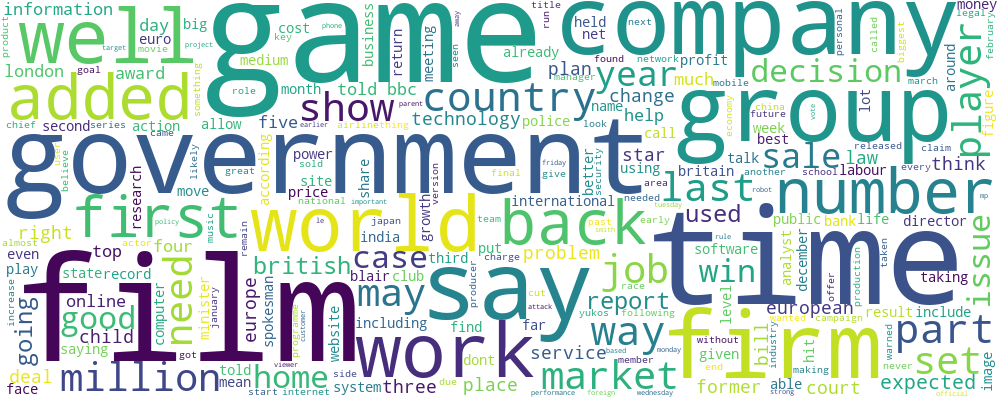

In [9]:
# Import the wordcloud library
from wordcloud import WordCloud

# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=400, background_color="white", max_words=250, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(str(doc_cleaned_cloud))

# Visualize the word cloud
wordcloud.to_image()

<h2>Filtering POS tags: <b>Nouns, Proper Nouns and Adjectives</h2></b>

In [10]:
def lemmatization(texts,allowed_postags=['NOUN', 'PROPN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out=[]
    for sent in texts:
        doc=nlp(' '.join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# spacy for lemmatization
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
data_lemmatized = lemmatization(doc_cleaned, allowed_postags=['NOUN', 'PROPN', 'ADJ'])

print(len(data_lemmatized[0]))

177


<h2>Data transformation: Creating dictionary and corpus</h2>

In [11]:
# create dictionary
id2word = corpora.Dictionary(data_lemmatized)

#create corpus
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# sample
print(corpus[2])

[(20, 2), (26, 1), (48, 1), (61, 1), (77, 1), (83, 1), (95, 4), (122, 3), (124, 1), (132, 1), (154, 1), (212, 1), (213, 1), (214, 1), (215, 1), (216, 1), (217, 1), (218, 1), (219, 1), (220, 2), (221, 1), (222, 4), (223, 1), (224, 1), (225, 1), (226, 1), (227, 1), (228, 1), (229, 1), (230, 1), (231, 1), (232, 1), (233, 1), (234, 1), (235, 1), (236, 1), (237, 2), (238, 1), (239, 1), (240, 1), (241, 1), (242, 1), (243, 1), (244, 3), (245, 1), (246, 3), (247, 1), (248, 1), (249, 1), (250, 1), (251, 1), (252, 1), (253, 1), (254, 2), (255, 1), (256, 1), (257, 2), (258, 1), (259, 1), (260, 1), (261, 1), (262, 1), (263, 1), (264, 1), (265, 7), (266, 1), (267, 1), (268, 1), (269, 1), (270, 1), (271, 1), (272, 1), (273, 2), (274, 1), (275, 1), (276, 1), (277, 3), (278, 6), (279, 6)]


<h2>Building bigrams and trigrams</h2>

In [12]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_lemmatized, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_lemmatized], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(len(trigram_mod[bigram_mod[data_lemmatized[0]]]))

173


In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'PROPN', 'ADJ']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_lemmatized)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)


# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized_bi = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'PROPN', 'ADJ'])

print(data_lemmatized_bi[0])

['sale', 'time', 'warner', 'profit', 'quarterly', 'profit', 'medium', 'giant', 'timewarner', 'month', 'december', 'yearearlier', 'firm', 'big', 'investor', 'google', 'sale', 'highspeed', 'internet', 'connection', 'high', 'advert', 'sale', 'timewarner', 'fourth_quart', 'sale', 'profit', 'oneoff', 'profit', 'dip', 'warner', 'bros', 'le', 'user', 'aol', 'time', 'warner', 'friday', 'google', 'internet', 'business', 'fortune', 'subscriber', 'profit', 'low', 'quarter', 'company', 'exceptional', 'item', 'strong', 'internet', 'advertising', 'revenue', 'hope', 'increase', 'subscriber', 'online', 'service', 'free', 'timewarner', 'internet', 'customer', 'sign', 'aol', 'customer', 'highspeed', 'broadband', 'timewarner', 'restate', 'result', 'probe', 'security', 'exchange', 'commission', 'sec', 'close', 'concluding', 'time', 'warner', 'fourth_quarter', 'profit', 'well', 'analyst', 'expectation', 'film', 'division', 'profit', 'slump', 'boxoffice', 'alexander', 'catwoman', 'sharp', 'contrast', 'yeare

In [15]:
# Create Dictionary
id2word_bi = corpora.Dictionary(data_lemmatized_bi)

# Create Corpus
texts_bi = data_lemmatized_bi

# Term Document Frequency
corpus_bi = [id2word_bi.doc2bow(text) for text in texts_bi]

# View
print(corpus_bi[:1])

[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 2), (32, 1), (33, 1), (34, 1), (35, 2), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 2), (46, 1), (47, 1), (48, 2), (49, 1), (50, 2), (51, 2), (52, 1), (53, 1), (54, 1), (55, 4), (56, 1), (57, 1), (58, 1), (59, 1), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 2), (75, 1), (76, 9), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 2), (86, 4), (87, 1), (88, 1), (89, 1), (90, 5), (91, 2), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 3), (99, 2), (100, 2), (101, 3), (102, 7), (103, 1), (104, 1), (105, 1), (106, 1), (107, 4), (108, 1), (109, 1), (110, 1)

<h2>Finding the optimal k for the best coherence score</h2>

In [16]:
coherence = []
for k in range(10,18):
    print('Round: '+str(k))
    lda_model_bi = gensim.models.ldamodel.LdaModel(corpus=corpus_bi,
                                           id2word=id2word_bi,
                                           num_topics=k, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    
    coherence_model_lda_bi = CoherenceModel(model=lda_model_bi, texts=data_lemmatized_bi, dictionary=id2word_bi, coherence='c_v')
                                                
    coherence.append((k,coherence_model_lda_bi.get_coherence()))

Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17


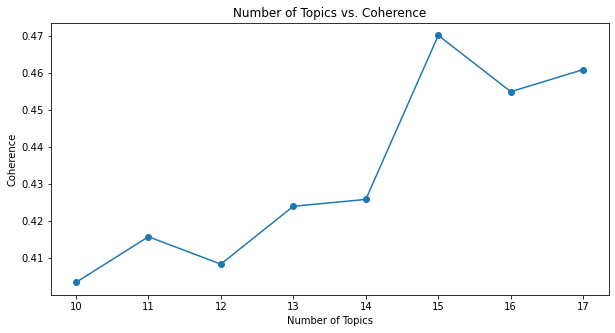

In [17]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

plt.figure(figsize=(10,5))
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

<h2>Finding the optimal k for the best perplexity score</h2>

In [18]:
perplexity = []
for k in range(10,18):
    print('Round: '+str(k))
    lda_model_bi = gensim.models.ldamodel.LdaModel(corpus=corpus_bi,
                                           id2word=id2word_bi,
                                           num_topics=k, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
                                                
    perplexity.append((k,lda_model_bi.log_perplexity(corpus_bi)))

Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17


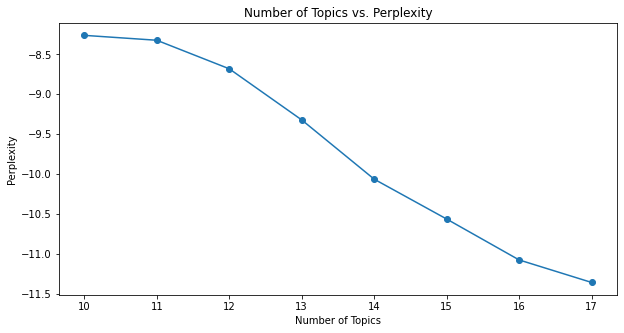

In [19]:
x_per = [x[0] for x in perplexity]
y_per = [x[1] for x in perplexity]

plt.figure(figsize=(10,5))
plt.plot(x_per,y_per)
plt.scatter(x_per,y_per)
plt.title('Number of Topics vs. Perplexity')
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.xticks(x_per)
plt.show()

<h2>Optimal k for the best coherence score</b>

In [20]:
Lda = gensim.models.ldamodel.LdaModel
lda_model_bi = gensim.models.ldamodel.LdaModel(corpus=corpus_bi,
                                           id2word=id2word_bi,
                                           num_topics=15, 
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [21]:
# Compute Perplexity # lower the better
print('Perplexity: ', lda_model_bi.log_perplexity(corpus_bi))

Perplexity:  -10.560560534328099


In [22]:
coherence_model_lda_bi = CoherenceModel(model=lda_model_bi, texts=data_lemmatized_bi, dictionary=id2word_bi, coherence='c_v')
coherence_lda_bi = coherence_model_lda_bi.get_coherence()
print(coherence_lda_bi)

0.47012987417308405


In [23]:
pprint(lda_model_bi.print_topics(num_topics=15, num_words=10))

[(0,
  '0.038*"website" + 0.028*"name" + 0.026*"domain" + 0.019*"travel" + '
  '0.016*"heart" + 0.014*"championship" + 0.013*"chelsea" + 0.013*"operator" + '
  '0.009*"address" + 0.009*"race"'),
 (1,
  '0.017*"mobile_phone" + 0.017*"radio" + 0.014*"penalty" + 0.013*"tsunami" + '
  '0.012*"revolution" + 0.009*"disaster" + 0.009*"host" + 0.008*"aid" + '
  '0.008*"range" + 0.008*"james"'),
 (2,
  '0.038*"game" + 0.022*"player" + 0.014*"time" + 0.014*"good" + 0.012*"club" '
  '+ 0.012*"goal" + 0.010*"manager" + 0.009*"side" + 0.009*"world" + '
  '0.009*"team"'),
 (3,
  '0.018*"chelsea" + 0.015*"decision" + 0.012*"mutu" + 0.011*"sport" + '
  '0.010*"davis" + 0.010*"engine" + 0.009*"greek" + 0.009*"eye" + 0.009*"iaaf" '
  '+ 0.009*"case"'),
 (4,
  '0.013*"software" + 0.012*"information" + 0.012*"online" + 0.012*"industry" '
  '+ 0.011*"computer" + 0.011*"internet" + 0.010*"report" + 0.010*"child" + '
  '0.009*"microsoft" + 0.009*"program"'),
 (5,
  '0.017*"bill" + 0.015*"law" + 0.014*"govern

In [24]:
print('\nFile name and its corresponding topic id with probability:')
dic_topic_doc = {}
for index, doc in enumerate(data_lemmatized_bi):
    #for doc in doc_clean:
    bow = id2word_bi.doc2bow(doc)
    #get topic distribution of the ldamodel
    t = lda_model_bi.get_document_topics(bow)
    #sort the probability value in descending order to extract the top contributing topic id
    sorted_t = sorted(t, key=lambda x: x[1], reverse=True)
    #print only the filename
    print(filenames[index],sorted_t)
    #get the top scoring item
    top_item = sorted_t.pop(0)
    #create dictionary and keep key as topic id and filename and probability in tuple as value
    dic_topic_doc.setdefault(top_item[0],[]).append((filenames[index],top_item[1]))


File name and its corresponding topic id with probability:
001.txt [(6, 0.59878653), (1, 0.23465335), (4, 0.09015591), (11, 0.05450705), (2, 0.017507292)]
002.txt [(6, 0.6717838), (11, 0.16493087), (3, 0.12718676), (4, 0.028567253)]
003.txt [(6, 0.98384404)]
004.txt [(6, 0.96048236), (2, 0.023938963)]
005.txt [(12, 0.49952883), (6, 0.2696637), (4, 0.11798373), (2, 0.07694871), (11, 0.029424496)]
006.txt [(6, 0.97755784)]
007.txt [(6, 0.7198854), (10, 0.26449746)]
008.txt [(6, 0.62354404), (13, 0.33309188), (14, 0.029375559)]
009.txt [(8, 0.6852543), (4, 0.15167455), (6, 0.14650272)]
010.txt [(6, 0.39822218), (12, 0.28783783), (4, 0.07746496), (3, 0.077198066), (5, 0.06172076), (2, 0.04996389), (8, 0.026053956), (7, 0.014679677)]
011.txt [(6, 0.44243646), (4, 0.28120694), (8, 0.21874864), (2, 0.02886178), (9, 0.015113207)]
012.txt [(1, 0.53883064), (6, 0.32428467), (4, 0.12506427)]
013.txt [(6, 0.81327033), (3, 0.13982907), (4, 0.03503327)]
014.txt [(2, 0.80010396), (6, 0.098733746), (

129.txt [(4, 0.47624347), (6, 0.13690154), (14, 0.11110142), (7, 0.11025801), (2, 0.09388086), (5, 0.036038935), (0, 0.02356691)]
130.txt [(6, 0.6083741), (14, 0.22785953), (3, 0.051563997), (7, 0.04806178), (2, 0.02946119), (8, 0.027996227)]
131.txt [(6, 0.9063597), (2, 0.06574687), (4, 0.013804171)]
132.txt [(6, 0.6511617), (2, 0.18942285), (13, 0.074439004), (12, 0.065014325)]
133.txt [(4, 0.2685138), (10, 0.21741286), (3, 0.19865558), (6, 0.15076444), (7, 0.11866814), (1, 0.030258117)]
134.txt [(6, 0.65016145), (2, 0.08664015), (4, 0.08205796), (10, 0.06648088), (7, 0.031184567), (3, 0.02084095), (8, 0.019549582), (0, 0.019167343), (12, 0.019026827)]
135.txt [(6, 0.46294945), (3, 0.16014266), (14, 0.1300016), (11, 0.125935), (4, 0.0873467), (8, 0.024239387)]
136.txt [(6, 0.52045), (4, 0.16078153), (5, 0.1145969), (7, 0.09839857), (2, 0.05629326), (14, 0.044283528)]
137.txt [(6, 0.5900952), (10, 0.10220924), (14, 0.09680936), (5, 0.07006609), (11, 0.056322306), (4, 0.040191818), (2,

228.txt [(11, 0.39141756), (7, 0.1517651), (4, 0.14955947), (2, 0.10725518), (6, 0.08736905), (1, 0.08603038), (3, 0.013762591), (14, 0.010719321)]
229.txt [(4, 0.27079442), (6, 0.26334482), (2, 0.16890253), (7, 0.14508986), (14, 0.061044615), (11, 0.043312136), (3, 0.029333409), (0, 0.016523354)]
230.txt [(14, 0.4473444), (7, 0.26688725), (1, 0.1395923), (4, 0.057838637), (11, 0.039170135), (0, 0.036631305)]
231.txt [(4, 0.5221707), (11, 0.15784597), (2, 0.14034668), (7, 0.0985457), (6, 0.03769655), (14, 0.020280138), (3, 0.02026541)]
232.txt [(4, 0.31322077), (2, 0.19073027), (7, 0.15010795), (0, 0.12546134), (3, 0.09574112), (1, 0.06385911), (14, 0.048674934)]
233.txt [(2, 0.33324328), (11, 0.23554844), (14, 0.18945971), (6, 0.10139427), (3, 0.0874592), (1, 0.03939166)]
234.txt [(7, 0.6185119), (6, 0.098739624), (11, 0.07242728), (2, 0.06367309), (1, 0.056435753), (0, 0.054363344), (4, 0.02663422)]
235.txt [(7, 0.2740729), (6, 0.25699583), (11, 0.19424695), (2, 0.13902976), (4, 0.12

In [25]:
print('\nTopic id, number of documents, list of documents with probability and represented topic words:')
for key,value in dic_topic_doc.items():
    sorted_value = sorted(value, key=lambda x: x[1], reverse=True)
    print(key,len(value),sorted_value)
    #print the topic word and most represented doc
    print(lda_model_bi.print_topic(key,5) + "\n\n")


Topic id, number of documents, list of documents with probability and represented topic words:
6 52 [('003.txt', 0.98384404), ('024.txt', 0.9838049), ('006.txt', 0.97755784), ('004.txt', 0.96048236), ('131.txt', 0.9063597), ('127.txt', 0.8847764), ('064.txt', 0.8742555), ('140.txt', 0.8610708), ('013.txt', 0.81327033), ('025.txt', 0.8065538), ('128.txt', 0.7906184), ('138.txt', 0.78054076), ('142.txt', 0.75858533), ('007.txt', 0.7198854), ('144.txt', 0.6983216), ('141.txt', 0.68803394), ('002.txt', 0.6717838), ('126.txt', 0.6642127), ('132.txt', 0.6511617), ('134.txt', 0.65016145), ('139.txt', 0.6465651), ('022.txt', 0.6439622), ('143.txt', 0.62788117), ('147.txt', 0.62621444), ('008.txt', 0.62354404), ('041.txt', 0.609974), ('149.txt', 0.6087769), ('130.txt', 0.6083741), ('001.txt', 0.59878653), ('137.txt', 0.5900952), ('146.txt', 0.56298375), ('145.txt', 0.5425091), ('150.txt', 0.5371259), ('136.txt', 0.52045), ('017.txt', 0.5117869), ('018.txt', 0.49714407), ('242.txt', 0.46637383)

<h2>Visualising the topics</h2>

In [26]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_bi, corpus_bi, id2word_bi, mds = 'mmds')
vis

C:\Users\liko_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6     -0.201002  0.266339       1        1  17.817286
2     -0.022923  0.367631       2        1  17.145550
4     -0.360167  0.049321       3        1  14.678472
11     0.172611  0.285520       4        1  11.287174
5      0.315640  0.003419       5        1   8.932348
7     -0.235580  0.068028       6        1   7.670064
14     0.153239 -0.294313       7        1   6.441812
3      0.197504  0.091839       8        1   5.357555
1     -0.069986 -0.243689       9        1   2.623397
0     -0.177593 -0.179389      10        1   2.541612
8      0.033264  0.013038      11        1   2.119701
10     0.143127 -0.108596      12        1   1.474257
13    -0.020127 -0.092442      13        1   0.703941
9      0.050642 -0.097956      14        1   0.628210
12     0.021351 -0.128752      15        1   0.578619, topic_info=              Term        Freq       Total Category  logprob  loglift
1628          game  246.000000  246.000000  Default  30.0000  30.0000
35            film  123.000000  123.000000  Default  29.0000  29.0000
612         player  122.000000  122.000000  Default  28.0000  28.0000
303           good  158.000000  158.000000  Default  27.0000  27.0000
3640       digital   72.000000   72.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1947       spanish    1.697217   32.486688  Topic15  -4.6860   2.2004
402    speculation    0.268252    4.340925  Topic15  -6.5308   2.3684
929        overall    0.298830   11.479543  Topic15  -6.4229   1.5038
3078  championship    0.217074   11.935367  Topic15  -6.7425   1.1453
382           lift    0.204116    1.484630  Topic15  -6.8040   3.1680

[756 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1725      4  0.925221     academy
2564     13  0.589750  acceptable
961       3  0.754068      access
961       4  0.111714      access
961       5  0.139642      access
...     ...       ...         ...
1000      3  0.758330       young
1000      4  0.189582       young
265       1  0.943207     yugansk
266       1  0.966316       yukos
2756      6  0.934849      zambia

[1229 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 5, 12, 6, 8, 15, 4, 2, 1, 9, 11, 14, 10, 13])

In [27]:
topic_data = pyLDAvis.gensim_models.prepare(lda_model_bi, corpus_bi, id2word_bi)
all_topics = {}
num_terms = 15 # Adjust number of words to represent each topic
lambd = 0.6 # Adjust this accordingly based on tuning above
for i in range(1,16): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-lambd)+topic['logprob']*lambd
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values
pd.DataFrame(all_topics).T

C:\Users\liko_\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Topic 1,market,price,company,sale,bank,analyst,vehicle,job,firm,consumer,profit,europe,dollar,share,growth
Topic 2,game,player,club,goal,manager,time,team,win,good,football,side,smith,arsenal,season,top
Topic 3,software,computer,information,industry,internet,online,child,report,microsoft,program,search,google,email,apple,window
Topic 4,film,digital,robot,award,movie,medium,music,good,project,content,technology,sony,camera,box,video
Topic 5,bill,law,police,spanish,labour,scott,lord,government,act,tory,minister,hunt,muslim,english,common
Topic 6,image,site,research,network,phone,mobile,message,number,multimedia,security,customer,device,service,picture,virus
Topic 7,poster,airline,paper,bad,campaign,air,confidence,cheap,home,hand,serious,transport,passenger,norwich,word
Topic 8,chelsea,mutu,davis,engine,decision,greek,eye,iaaf,sport,thanou,tape,kenteris,white,school,mass
Topic 9,mobile_phone,radio,penalty,tsunami,revolution,disaster,host,aid,range,magic,portsmouth,sir,jamie,sri,james
Topic 10,website,domain,travel,name,heart,championship,operator,address,icann,approval,galla,bnp,gartner,telecom,wonderful
